<h2> Make a plot of AUC vs. rt-window slices </h2>
dataset: MTBLS72_uplc_pos_classifer_15ppm_bw2

In [2]:
import time

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.cross_validation import cross_val_score
#from sklearn.model_selection import StratifiedShuffleSplit
#from sklearn.model_selection import cross_val_score

from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.utils import shuffle

from scipy import interp
import scipy.stats as stats

import pickle

# My libraries
import data.preprocessing as preproc
import project_fxns.rt_window_prediction as rtwin

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
toy = pd.DataFrame([[1,2,3,0],
                    [0,0,0,0],
                  [0.5,1,0,0]], dtype=float,
                  columns=['1', '2', '3', '4'],
                  index=['sample_%s' % i for i in range(1,4)])

preproc.prevalence_threshold(toy)


Requiring sample to be present in 0.5 percent of samples


,1,2
sample_1,1.0,2.0
sample_2,0.0,0.0
sample_3,0.5,1.0


<h2> Get the xcms data </h2>

In [4]:
### Subdivide the data into a feature table
local_path = '/home/irockafe/Dropbox (MIT)/Alm_Lab/'\
'projects'
data_path = local_path + '/revo_healthcare/data/processed/MTBLS72/positive_mode/'\
'mtbls_no_retcor_bw2.csv'

## Import the data and remove extraneous columns
df = pd.read_csv(data_path, index_col=0)
# Replace X's at the beginning of sample names
new_idx = [i.replace('X', '') for i in df.columns]
df.columns = new_idx
print df.columns

df.shape
df.head()
# Make a new index of mz:rt
mz = df.loc[:,"mz"].astype('str')
rt = df.loc[:,"rt"].astype('str')
idx = mz+':'+rt
df.index = idx

# separate samples from xcms/camera things to make feature table
not_samples = ['mz', 'mzmin', 'mzmax', 'rt', 'rtmin', 'rtmax', 
               'npeaks', 'positive_mode', 
               ]
samples_list = df.columns.difference(not_samples)
mz_rt_df = df[not_samples]

# Convert to (samples x features) format - our standard
X_df_raw = df[samples_list].T
new_idx = [i.replace('X', '') for i in X_df_raw.index]
X_df_raw.index = new_idx







Index([u'mz', u'mzmin', u'mzmax', u'rt', u'rtmin', u'rtmax', u'npeaks',
       u'positive_mode', u'20120829_Howard_POS_07', u'20120829_Howard_POS_08',
       ...
       u'20120829_Howard_POS_89', u'20120829_Howard_POS_90',
       u'20120829_Howard_POS_91', u'20120829_Howard_POS_92',
       u'20120829_Howard_POS_93', u'20120829_Howard_POS_94',
       u'20120829_Howard_POS_95', u'20120829_Howard_POS_96',
       u'20120829_Howard_POS_98', u'20120829_Howard_POS_99'],
      dtype='object', length=262)


<h2> Get mappings between sample names, file names, and sample classes </h2>


In [5]:
# get mapping between sample name and sample class
path_sample_class_map = (local_path +
        '/revo_healthcare/data/raw/MTBLS72/s_Plasma_AD_Lipidomics.txt')
class_column = 'Factor Value[Cognitive Status]'

class_df = pd.read_csv(path_sample_class_map,
                      sep='\t')
# Set index as sample name
class_df.set_index('Sample Name', inplace=True)
class_df = class_df[class_column]

# select only positive values from positive-ion mode
class_df = class_df[class_df.index.str.contains('POS')]
print class_df.head(10)
print "Class label shape: ", class_df.shape
print "feature table shape: ", X_df_raw.shape

#class_df.rename('class', inplace=True)
print class_df.head()
print '\n\nClass labels: ', pd.unique(class_df.values)


# Get case and control dataframes
case_labels = class_df[class_df=='aMCI/AD'].index
control_labels = class_df[class_df == 'Normal Control'].index
case = X_df_raw.loc[case_labels]
control = X_df_raw.loc[control_labels]

Sample Name
20120829_Howard_POS_129    aMCI/AD
20120829_Howard_POS_130    aMCI/AD
20120829_Howard_POS_131    aMCI/AD
20120829_Howard_POS_132    aMCI/AD
20120829_Howard_POS_134    aMCI/AD
20120829_Howard_POS_135    aMCI/AD
20120829_Howard_POS_137    aMCI/AD
20120829_Howard_POS_142    aMCI/AD
20120829_Howard_POS_158    aMCI/AD
20120829_Howard_POS_160    aMCI/AD
Name: Factor Value[Cognitive Status], dtype: object
Class label shape:  (323,)
feature table shape:  (254, 1417)
Sample Name
20120829_Howard_POS_129    aMCI/AD
20120829_Howard_POS_130    aMCI/AD
20120829_Howard_POS_131    aMCI/AD
20120829_Howard_POS_132    aMCI/AD
20120829_Howard_POS_134    aMCI/AD
Name: Factor Value[Cognitive Status], dtype: object


Class labels:  ['aMCI/AD' 'Normal Control' 'Not Applicable']


<h2> Convert class labels to binary </h2>
asser that X and y match one another's order
<h4>Control is 0, alzheimers is 1 </h4>
Note that the 'Not Applicable' class is not part of my 
dataframe, X, so when I select only  we make sure that X and y refer 
to the same samples, all the 'Not Applicable' samples are dropped

In [15]:
# Match between feature table and metadata and assert that they're in the same order.
# then define the numpy-arrays for X and y
class_df = class_df[X_df_raw.index].sort_index()
X_df_raw = X_df_raw.sort_index()
print 'Class values:', class_df.unique()
assert (class_df.index == X_df_raw.index).all()

# convert classes to numbers
le = preprocessing.LabelEncoder()
le.fit(class_df)
y = le.transform(class_df)
print y
print "class-labels: ", le.classes_

Class values: ['Normal Control' 'aMCI/AD']
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 1 0 1 1 0 1 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 1 1 1 1 0 0 1 1 1 1 0 1 0 1 0 1 1 0 1 1
 1 0 1 0 1 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 1 1 1 1 0 0 1 0 1
 1 1 0 1 0 1 1 1 0 0 0 1 0 0 1 1 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 1 1 1 0 0
 0 0 0 1 0 1 0 1 0 0 1 0 1 0 0 0 1 1 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 1 1 1
 0 0 0 0 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
class-labels:  ['Normal Control' 'aMCI/AD']


<h2> Preprocess feature table </h2>
Try to remove systematic intensity biases between samples by correcting for dilution factors 

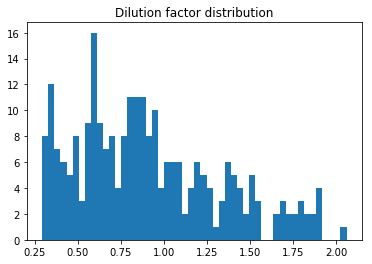

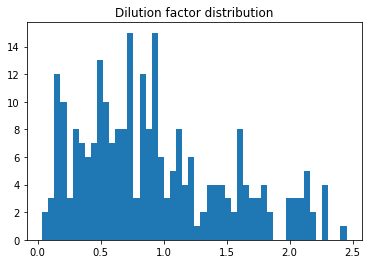

In [7]:
# fill nan values with 1/2 the minimum from each sample
fill_val = X_df_raw.min(axis=1) / 2.0
# must transpose, b/c fillna only operates along columns
X_df_filled = X_df_raw.T.fillna(value=fill_val, ).T

X_pqn_df_raw = preproc.correct_dilution_factor(X_df_raw, plot=True)
X_pqn_df_filled = preproc.correct_dilution_factor(X_df_filled, plot=True)

X_pqn_df_filled_log = np.log10(X_pqn_df_filled)

<h2> There is a bias in intensity values between case and control. Can I eliminate that through some normalization? </h2>
sort of - for non-log transformed intensities, Mann-whitney test has p>0.2. For log-transformed, p~0.3
<br>
<h2> It seems really weird to me that almost half of all features are have a p-vals less than 0.05  </h2>
Remember that the case group is elderly people who go on to develop alzheimers 2 years later. You wouldn't expect this wild of a difference. Maybe my processing was wrong...?



Note that the pvals reported assume normality - I didn't do them via permutation test, because laziness at current moment

Raw intensities




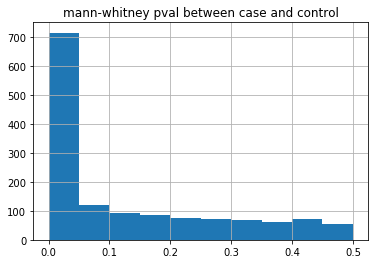

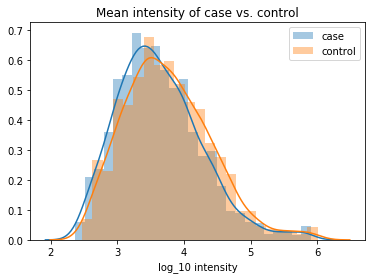

pval (MannW) of intensities between case and control:  6.1537580727e-08
**************************************************
NaN filled with 1/2 min


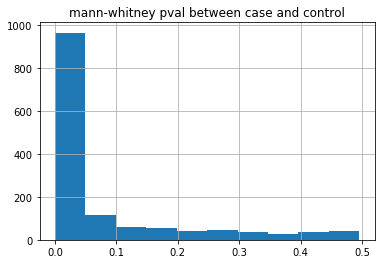

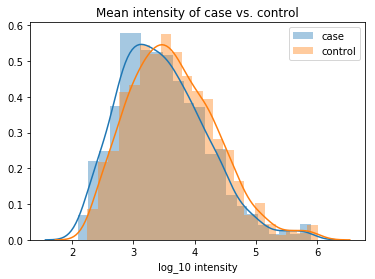

pval (MannW) of intensities between case and control:  6.94213237893e-11
**************************************************
 Raw pqn_normalized


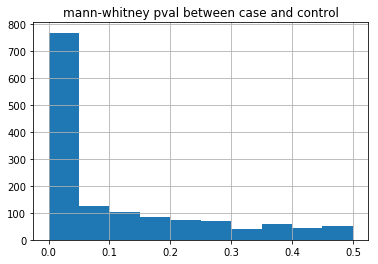

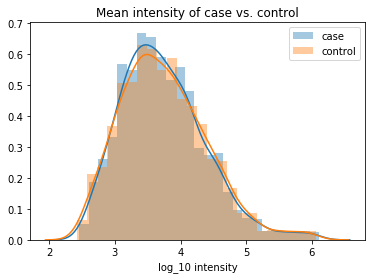

pval (MannW) of intensities between case and control:  0.331169121043
**************************************************
 NaN filled with 1/2 min, pqn normalized


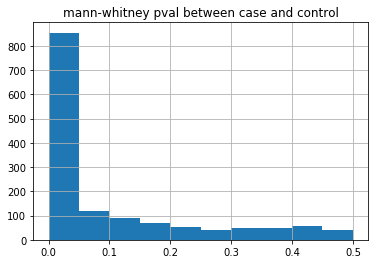

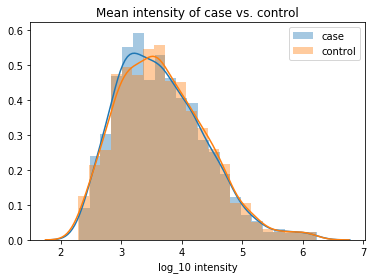

pval (MannW) of intensities between case and control:  0.194422958326
**************************************************
 NaN filled with 1/2 min, pqn normalized, log10 transformed


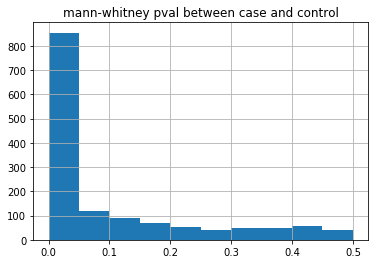

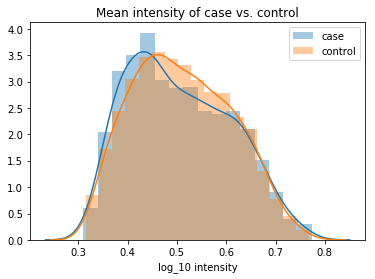

pval (MannW) of intensities between case and control:  0.0325050936732


In [84]:
# Do mann-whitney on case vs control
def mw_pval_dist(case, control):
    '''
    case - dataframe containing case
    control - dataframe with control samples
        All should have same features (columns)
    '''
    # get parametric pvals
    mann_whitney_vals = pd.DataFrame(np.full([case.shape[1],2], np.nan),
                              index=case.columns, columns= ['u', 'pval'])
    for idx, case_vals in case.iteritems():
        control_vals = control[idx]
        u, pval = stats.mannwhitneyu(case_vals, control_vals)
        mann_whitney_vals.loc[idx, 'u'] = u
        mann_whitney_vals.loc[idx, 'pval'] = pval
    
    # plot mw pval distribution
    mann_whitney_vals.hist('pval')
    plt.title('mann-whitney pval between case and control')
    plt.show()
    
    # plot distribution of mean intensities
    case_mean = case.mean(axis=0)
    ctrl_mean = control.mean(axis=0)
    sns.distplot(np.log10(case_mean), label='case')
    sns.distplot(np.log10(ctrl_mean), label='control')
    plt.xlabel('log_10 intensity')
    plt.title('Mean intensity of case vs. control')
    plt.legend()
    plt.show()
    u, pval = stats.mannwhitneyu(case_mean, ctrl_mean)
    print 'pval (MannW) of intensities between case and control: ', pval
    
print('Raw intensities\n\n')
mw_pval_dist(X_df_raw.loc[case_labels], X_df_raw.loc[control_labels])

print('*'*50+'\nNaN filled with 1/2 min')
mw_pval_dist(X_df_filled.loc[case_labels], X_df_filled.loc[control_labels])

print('*'*50+'\n Raw pqn_normalized')
mw_pval_dist(X_pqn_df_raw.loc[case_labels], X_pqn_df_raw.loc[control_labels])

print('*'*50+'\n NaN filled with 1/2 min, pqn normalized')
mw_pval_dist(X_pqn_df_filled.loc[case_labels], X_pqn_df_filled.loc[control_labels])

print('*'*50+'\n NaN filled with 1/2 min, pqn normalized, log10 transformed')
mw_pval_dist(X_pqn_df_filled_log.loc[case_labels], 
             X_pqn_df_filled_log.loc[control_labels])



<h2> Run rt-window classifiers and capture the auc distributions
to plot </h2>

RT plot (0.0, 132.3533022)
661.766511
998.775098907


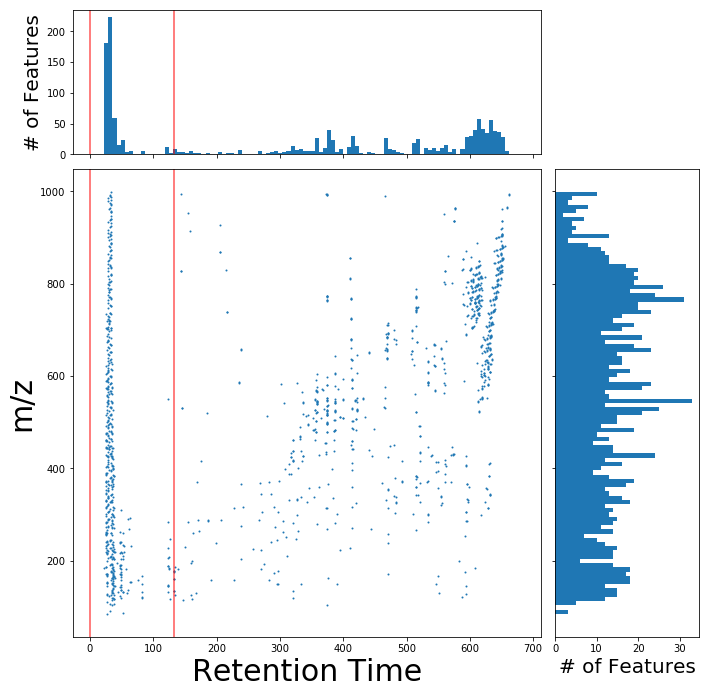

slice shape (254, 533)
y shape (254,)
0.0% done! 4.11143803596s elapsed
20.0% done! 49.395622015s elapsed
40.0% done! 87.2168409824s elapsed
60.0% done! 126.640625954s elapsed
80.0% done! 165.827847004s elapsed


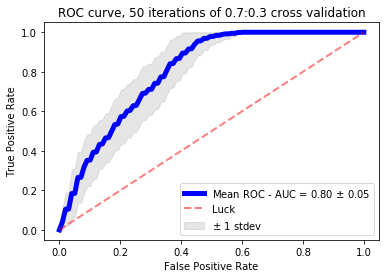




--------------------------------------------------NEXT ROUND--------------------------------------------------



RT plot (66.176651100000001, 198.52995329999999)
661.766511
998.775098907


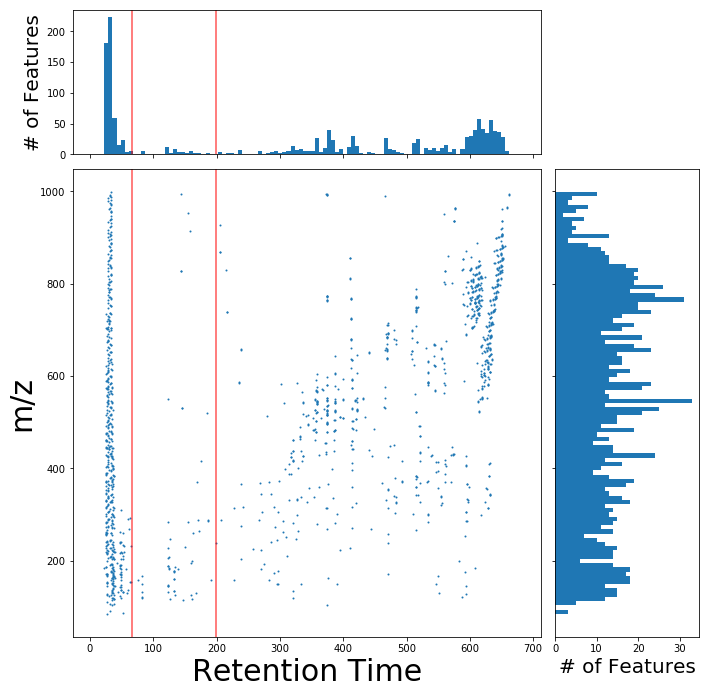

slice shape (254, 55)
y shape (254,)
0.0% done! 3.25019097328s elapsed
20.0% done! 35.9901101589s elapsed
40.0% done! 68.2285709381s elapsed
60.0% done! 100.419765949s elapsed
80.0% done! 133.776474953s elapsed


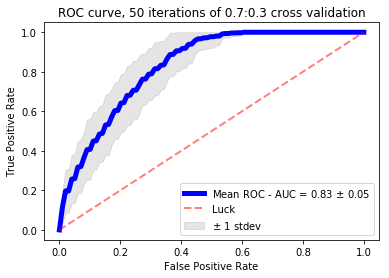




--------------------------------------------------NEXT ROUND--------------------------------------------------



RT plot (132.3533022, 264.7066044)
661.766511
998.775098907


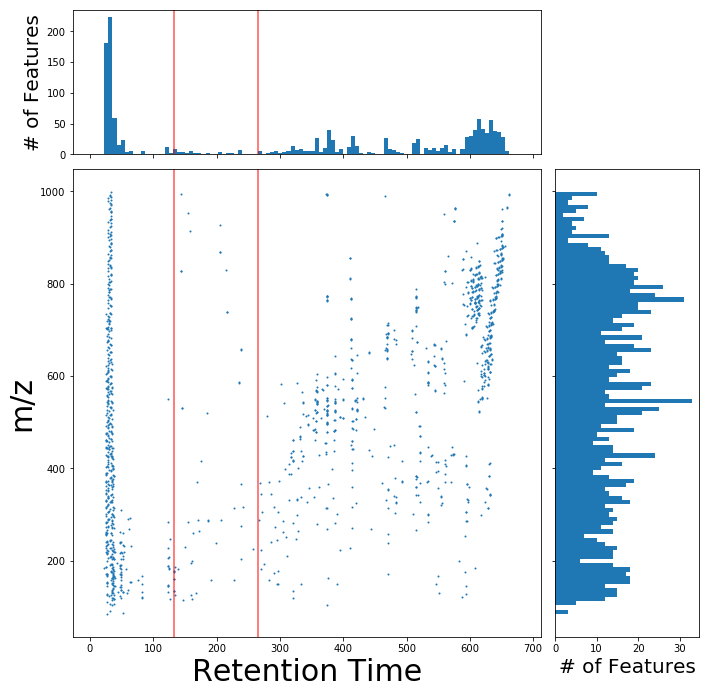

slice shape (254, 52)
y shape (254,)
0.0% done! 3.21645998955s elapsed
20.0% done! 35.6365098953s elapsed
40.0% done! 68.7290439606s elapsed
60.0% done! 110.569700003s elapsed
80.0% done! 142.466279984s elapsed


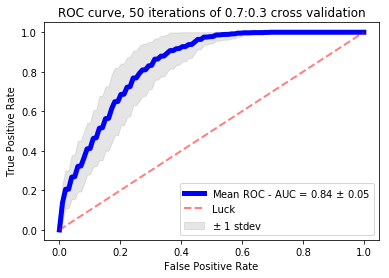




--------------------------------------------------NEXT ROUND--------------------------------------------------



RT plot (198.52995329999999, 330.88325550000002)
661.766511
998.775098907


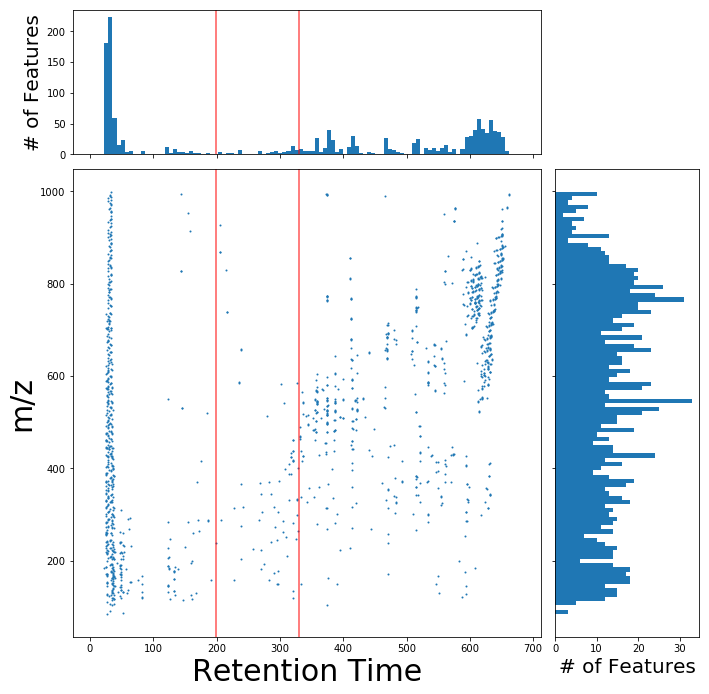

slice shape (254, 71)
y shape (254,)
0.0% done! 3.89097690582s elapsed
20.0% done! 45.0667259693s elapsed
40.0% done! 78.8733110428s elapsed
60.0% done! 112.35766387s elapsed
80.0% done! 147.059731007s elapsed


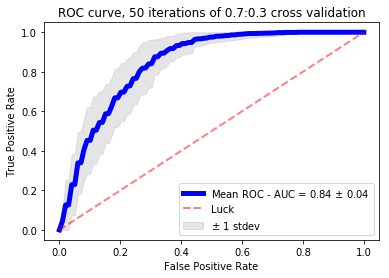




--------------------------------------------------NEXT ROUND--------------------------------------------------



RT plot (264.7066044, 397.05990659999998)
661.766511
998.775098907


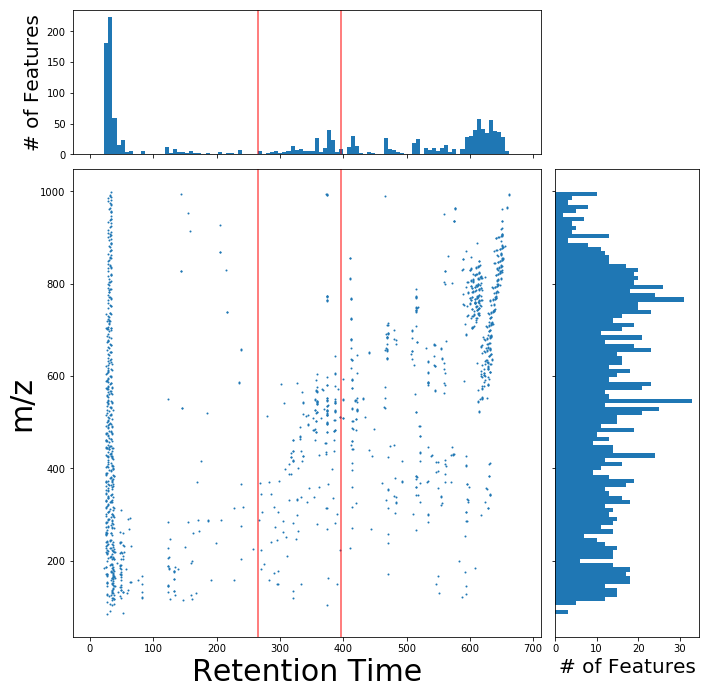

slice shape (254, 188)
y shape (254,)
0.0% done! 3.50265693665s elapsed
20.0% done! 38.5429589748s elapsed
40.0% done! 75.7618148327s elapsed
60.0% done! 115.86537981s elapsed
80.0% done! 154.135208845s elapsed


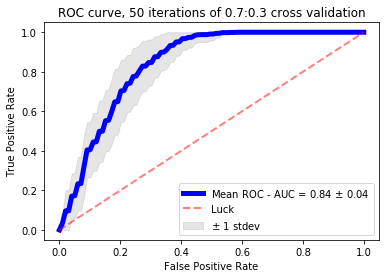




--------------------------------------------------NEXT ROUND--------------------------------------------------



RT plot (330.88325550000002, 463.23655770000005)
661.766511
998.775098907


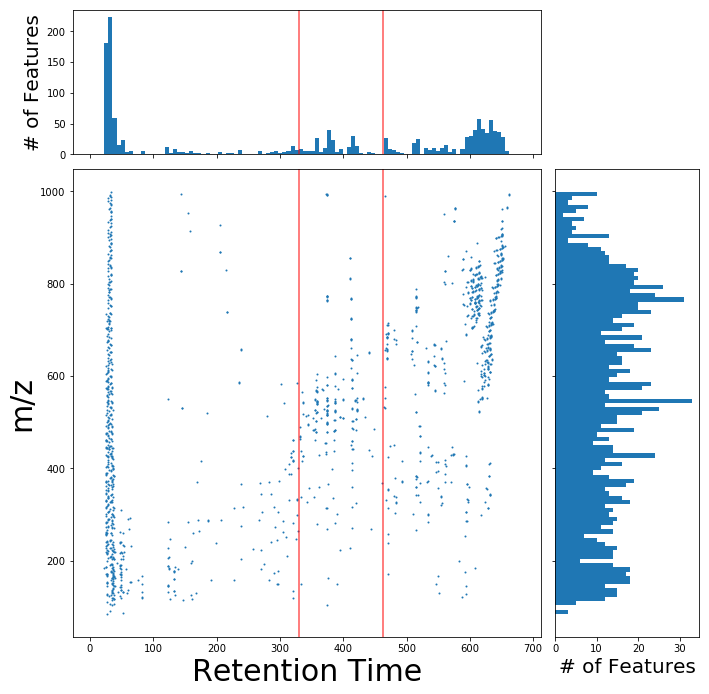

slice shape (254, 206)
y shape (254,)
0.0% done! 4.43695616722s elapsed
20.0% done! 43.1770031452s elapsed
40.0% done! 86.0717480183s elapsed
60.0% done! 122.841770172s elapsed
80.0% done! 162.958274126s elapsed


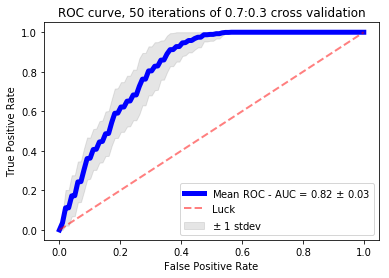




--------------------------------------------------NEXT ROUND--------------------------------------------------



RT plot (397.05990659999998, 529.41320880000001)
661.766511
998.775098907


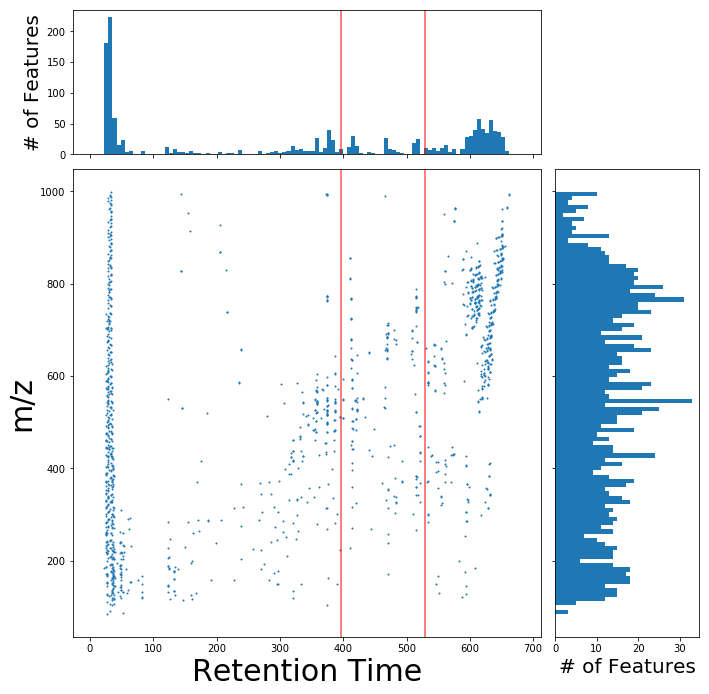

slice shape (254, 164)
y shape (254,)
0.0% done! 4.22068691254s elapsed
20.0% done! 38.6718430519s elapsed
40.0% done! 71.8045189381s elapsed
60.0% done! 105.797586918s elapsed
80.0% done! 141.912327051s elapsed


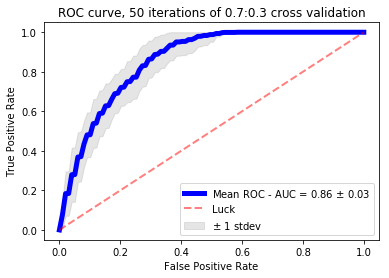




--------------------------------------------------NEXT ROUND--------------------------------------------------



RT plot (463.23655769999999, 595.58985989999996)
661.766511
998.775098907


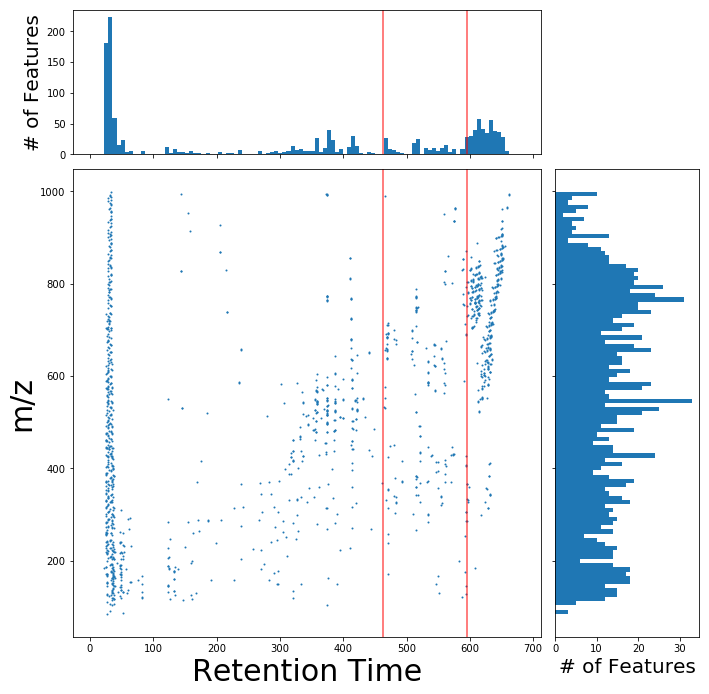

slice shape (254, 197)
y shape (254,)
0.0% done! 3.45988202095s elapsed
20.0% done! 38.47636199s elapsed
40.0% done! 72.5267839432s elapsed
60.0% done! 113.587913036s elapsed
80.0% done! 154.49684906s elapsed


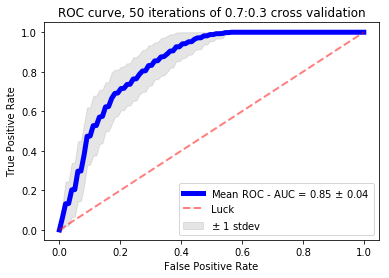




--------------------------------------------------NEXT ROUND--------------------------------------------------



RT plot (529.41320880000001, 661.76651100000004)
661.766511
998.775098907


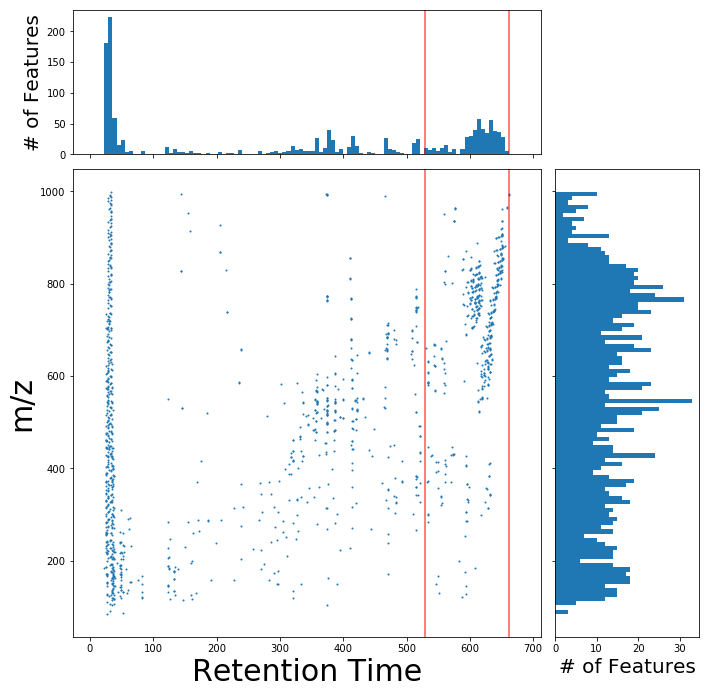

slice shape (254, 479)
y shape (254,)
0.0% done! 4.36047911644s elapsed
20.0% done! 43.7609460354s elapsed
40.0% done! 82.666544199s elapsed
60.0% done! 122.072871208s elapsed
80.0% done! 159.492021084s elapsed


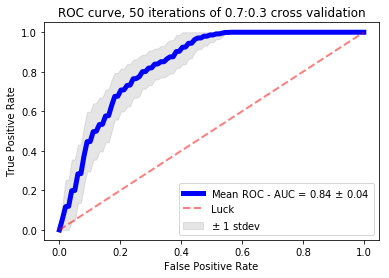




--------------------------------------------------NEXT ROUND--------------------------------------------------





array([[ 0.80909091,  0.85247934,  0.73553719,  0.83595041,  0.84132231,
         0.79710744,  0.83016529,  0.83801653,  0.79297521,  0.74752066,
         0.8322314 ,  0.73347107,  0.78099174,  0.77438017,  0.85619835,
         0.69090909,  0.76322314,  0.87355372,  0.81570248,  0.79214876,
         0.86198347,  0.80826446,  0.79834711,  0.78553719,  0.83884298,
         0.88305785,  0.8053719 ,  0.84834711,  0.78801653,  0.75413223,
         0.79338843,  0.85495868,  0.84090909,  0.73719008,  0.8661157 ,
         0.77231405,  0.89380165,  0.84214876,  0.76694215,  0.80247934,
         0.81983471,  0.86528926,  0.70413223,  0.80247934,  0.80247934,
         0.76239669,  0.73471074,  0.78966942,  0.69752066,  0.7892562 ],
       [ 0.8231405 ,  0.77727273,  0.74049587,  0.89793388,  0.83884298,
         0.86404959,  0.81735537,  0.84421488,  0.81694215,  0.81942149,
         0.86363636,  0.72561983,  0.84132231,  0.81570248,  0.88760331,
         0.71404959,  0.80743802,  0.88016529,  0.

In [145]:
# Add back mz, rt, etc. columns to feature table and reshape it to be
# (feats x samples)
X_pqn_df_filled_mzrt = pd.concat([df[not_samples].T, X_pqn_df_filled], 
                                 axis=0).T

# run a sliding windonw
# Make sliding window
min_val = 0
max_val = df['rt'].max()
width = max_val / 5
step = width / 2
sliding_window = rtwin.make_sliding_window(min_val, 
                                           max_val, width, step)

# Paths to plot things
path = ('/revo_healthcare/presentations/isaac_bats/'+
            'rt_window_plots/MTBLS72/')
output_path = local_path + path

# run classifier & plot on sliding window
n_iter = 50
test_size = 0.3
rf_trees = 1000
# Run rt-sliding-window classifier
rtwin.sliding_rt_window_aucs(X_pqn_df_filled_mzrt, y, sliding_window, not_samples,
                      rf_trees=rf_trees, n_iter=n_iter, test_size=test_size,
                      output_path=output_path)

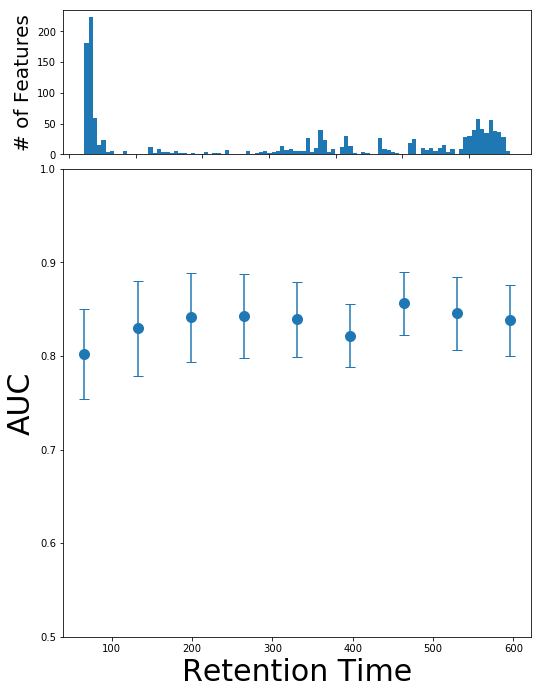

In [150]:
auc_vals = pickle.load(open(output_path+'/auc_vals.pkl', 'rb'))

fig_path = output_path + 'auc_vs_rt.pdf'
rtwin.plot_auc_vs_rt(auc_vals, sliding_window, df, fig_path)